In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.funcs import *
from pathlib import Path
from collections import defaultdict

# survival analysis
from lifelines.statistics import logrank_test

sns.set(font_scale = 1.25,
        style="whitegrid",
        rc={"figure.dpi":300, 'savefig.dpi':300, 'figure.figsize':(8,6)})

import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path.home() / "data/bioinfo_sm207"

In [4]:
response = pd.read_csv(
    Path.home() / "data/zuma7_signatures_log2/rchop_meta.csv",
    index_col=0)
response.head()

,Gene Expression Subgroup,Gender,Age,PFS event,PFS time,B.cells_group,Plasma.cells_group,T.cells.CD8_group,T.cells.CD4_group,T.cells.follicular.helper_group,...,g.Neutrophils.LD_group,g.NK_group,g.pDCs_group,g.Plasmablasts_group,g.T.CD4.Memory_group,g.T.CD4.Naive_group,g.T.CD8.Memory_group,g.T.CD8.Naive_group,g.T.gd.non.Vd2_group,g.T.gd.Vd2_group
DLBCL11537,GCB,M,58.0,0.0,3.991786,S02,unassigned,S02,S03,S03,...,low,low,low,low,low,low,low,high,low,low
DLBCL10477,ABC,F,53.0,1.0,0.290212,S04,unassigned,unassigned,unassigned,unassigned,...,low,low,low,low,low,low,low,low,low,low
DLBCL10471,ABC,M,83.0,1.0,6.488706,S05,unassigned,S02,S03,S03,...,low,low,low,low,low,low,low,high,low,low
DLBCL11186,ABC,M,71.0,0.0,10.086242,S04,S01,S03,S03,S01,...,low,low,low,low,low,low,low,low,low,low
DLBCL10542,ABC,M,30.0,1.0,0.536619,S04,unassigned,unassigned,unassigned,unassigned,...,low,low,low,low,high,low,low,low,low,low


In [5]:
arm = "Schmitz"
response = response.loc[response["Actual Arm Code"]==arm]
# remove old results
response = response.iloc[:, :5]
response['Actual Arm Code'] = arm

In [6]:
# ecotyper results
ecotyper_results = [d for d in (data_path/f"ecotyper_outs/{arm.lower()}_tpm").iterdir() if d.is_dir()]
len(ecotyper_results)

14

In [7]:
ecotyper_results[:3]

[PosixPath('/home/ubuntu/data/bioinfo_sm207/ecotyper_outs/schmitz_tpm/B.cells'),
 PosixPath('/home/ubuntu/data/bioinfo_sm207/ecotyper_outs/schmitz_tpm/Plasma.cells'),
 PosixPath('/home/ubuntu/data/bioinfo_sm207/ecotyper_outs/schmitz_tpm/T.cells.CD8')]

In [8]:
# add assignment to response for each output
for d in ecotyper_results:
    if d.name == "Ecotypes":
        fn = "ecotype_assignment.txt"
        col = "Ecotype"
    else:
        fn = "state_assignment.txt"
        col = "State"
    assignment = pd.read_csv(d/fn, sep="\t")

    # use ID as index
    assignment.set_index("ID", inplace=True)
    # remove index name
    assignment.index.name = None
    # assignment.index = assignment.index.map(lambda x: x.replace("_", "-"))
    # add the col to the response
    res = assignment[col]
    res.name = f"ecotyper_{d.name}_group"
    response = response.join(res)
    # fill na with unassigned 
    response[f"ecotyper_{d.name}_group"].fillna("Unassigned", inplace=True)

In [9]:
# granulator results with nnls_s0
nnls_s0 = pd.read_csv(data_path/f"granulator_outs/{arm.lower()}/nnls_ABIS_S0.csv", index_col=0)
nnls_s0.head()

,B.Memory,B.Naive,Basophils.LD,MAIT,mDCs,Monocytes.C,Monocytes.NC.I,Neutrophils.LD,NK,pDCs,Plasmablasts,T.CD4.Memory,T.CD4.Naive,T.CD8.Memory,T.CD8.Naive,T.gd.non.Vd2,T.gd.Vd2
DLBCL10450,15.90,1.77,0.00,0.00,0.00,0.35,0.35,0.71,0.0,1.06,8.48,2.12,0.00,0.00,1.06,0.0,0.00
DLBCL10451,39.22,0.00,0.35,1.41,0.00,0.35,1.41,3.89,0.0,0.35,1.77,0.00,0.00,0.00,0.00,0.0,1.06
DLBCL10452,0.00,5.65,0.00,2.47,0.71,1.41,1.06,0.71,0.0,0.71,4.24,0.71,0.71,0.00,0.35,0.0,0.00
DLBCL10453,17.31,0.00,0.00,2.83,0.35,0.00,0.35,1.41,0.0,0.35,4.59,0.35,1.06,0.00,0.00,0.0,0.00
DLBCL10454,4.59,8.83,0.35,6.36,0.00,0.00,0.71,1.77,0.0,2.12,5.30,0.00,1.06,1.41,0.00,0.0,1.06


<Axes: ylabel='Frequency'>

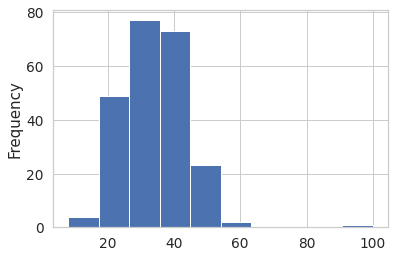

In [10]:
nnls_s0.sum(axis=1).plot.hist()

In [11]:
# inplace "_" with "-" in the index
# nnls_s0.index = nnls_s0.index.map(lambda x: x.replace("_", "-"))

# add granulator_ to the columns
nnls_s0.columns = nnls_s0.columns.map(lambda x: "granulator_" + x)

# add the assignment to the response
response = response.join(nnls_s0)
response.head()

,Gene Expression Subgroup,Gender,Age,PFS event,PFS time,Actual Arm Code,ecotyper_B.cells_group,ecotyper_Plasma.cells_group,ecotyper_T.cells.CD8_group,ecotyper_T.cells.CD4_group,...,granulator_Neutrophils.LD,granulator_NK,granulator_pDCs,granulator_Plasmablasts,granulator_T.CD4.Memory,granulator_T.CD4.Naive,granulator_T.CD8.Memory,granulator_T.CD8.Naive,granulator_T.gd.non.Vd2,granulator_T.gd.Vd2
DLBCL11537,GCB,M,58.0,0.0,3.991786,Schmitz,S02,Unassigned,S02,S03,...,2.83,0.0,1.06,3.18,4.24,0.00,1.06,0.0,0.00,0.00
DLBCL10477,ABC,F,53.0,1.0,0.290212,Schmitz,S04,Unassigned,Unassigned,Unassigned,...,0.71,0.0,0.35,3.18,0.71,0.00,0.00,0.0,0.00,0.00
DLBCL10471,ABC,M,83.0,1.0,6.488706,Schmitz,S05,Unassigned,S02,S02,...,1.77,0.0,1.41,4.59,0.00,0.35,2.83,0.0,0.00,0.00
DLBCL11186,ABC,M,71.0,0.0,10.086242,Schmitz,S04,S01,S03,S03,...,1.77,0.0,0.71,0.00,1.77,0.00,0.00,0.0,0.00,0.35
DLBCL10542,ABC,M,30.0,1.0,0.536619,Schmitz,S04,Unassigned,Unassigned,Unassigned,...,2.47,0.0,0.71,3.18,0.00,0.35,0.00,0.0,0.35,0.00


In [12]:
# save response
response.to_csv(data_path/f"step02_{arm.lower()}_response.csv")
response.to_parquet(data_path/f"step02_{arm.lower()}_response.parquet")